# Query ChEMBL for bioactivities involving protein kinases

ChEMBL stores a good amount of bioactivities for protein-ligand complexes in the field of kinases. Before running this notebook, we have identified the set of human protein kinases we want to target (`/human-kinases`) and under what identifiers these proteins are stored in ChEMBL (`/kinases-in-chembl`).

Now we can query ChEMBL for all bioactivities involving these targets but first we need to make sure we don't run into some common pitfalls (see section "Curate the dataset").

In [1]:
import sqlite3 as sql
import csv
import os
from pathlib import Path
from collections import defaultdict

import pandas as pd
from tqdm import tnrange
import numpy as np

In [2]:
REPO = (Path(_dh[-1]) / "..").resolve()
DATA = REPO / 'data'

# Map `chembl_targets` to `UniprotID`.

This file is generated with the `kinase-in-chembl` notebooks. Update it if you think there might be more ChEMBL targets.

In [3]:
kinases = pd.read_csv(DATA / "human_kinases_and_chembl_targets.chembl_27.csv")
kinases

,UniprotID,Name,chembl_targets,type,origin
0,A4QPH2,PI4KAP2,CHEMBL4105789,SINGLE PROTEIN,klifs
1,O00141,SGK1,CHEMBL2343,SINGLE PROTEIN,kinhub|klifs|pkinfam|reviewed_uniprot|dunbrack...
2,O00238,BMPR1B|BMR1B,CHEMBL5476,SINGLE PROTEIN,kinhub|klifs|pkinfam|reviewed_uniprot|dunbrack...
3,O00311,CDC7,CHEMBL5443,SINGLE PROTEIN,kinhub|klifs|pkinfam|reviewed_uniprot|dunbrack...
4,O00329,PIK3CD,CHEMBL3130,SINGLE PROTEIN,klifs|pkinfam
...,...,...,...,...,...
480,Q9Y5S2,CDC42BPB|MRCKB,CHEMBL5052,SINGLE PROTEIN,kinhub|klifs|pkinfam|reviewed_uniprot|dunbrack...
481,Q9Y616,IRAK3,CHEMBL5081,SINGLE PROTEIN,kinhub|klifs|pkinfam|reviewed_uniprot|dunbrack...
482,Q9Y6E0,STK24,CHEMBL5082,SINGLE PROTEIN,kinhub|klifs|pkinfam|reviewed_uniprot|dunbrack...
483,Q9Y6M4,KC1G3|CSNK1G3,CHEMBL5084,SINGLE PROTEIN,kinhub|klifs|pkinfam|reviewed_uniprot|dunbrack...


We are only interested in `SINGLE PROTEIN` targets for now.

In [4]:
df = kinases[kinases.type == "SINGLE PROTEIN"].drop("type", axis=1)
df

,UniprotID,Name,chembl_targets,origin
0,A4QPH2,PI4KAP2,CHEMBL4105789,klifs
1,O00141,SGK1,CHEMBL2343,kinhub|klifs|pkinfam|reviewed_uniprot|dunbrack...
2,O00238,BMPR1B|BMR1B,CHEMBL5476,kinhub|klifs|pkinfam|reviewed_uniprot|dunbrack...
3,O00311,CDC7,CHEMBL5443,kinhub|klifs|pkinfam|reviewed_uniprot|dunbrack...
4,O00329,PIK3CD,CHEMBL3130,klifs|pkinfam
...,...,...,...,...
480,Q9Y5S2,CDC42BPB|MRCKB,CHEMBL5052,kinhub|klifs|pkinfam|reviewed_uniprot|dunbrack...
481,Q9Y616,IRAK3,CHEMBL5081,kinhub|klifs|pkinfam|reviewed_uniprot|dunbrack...
482,Q9Y6E0,STK24,CHEMBL5082,kinhub|klifs|pkinfam|reviewed_uniprot|dunbrack...
483,Q9Y6M4,KC1G3|CSNK1G3,CHEMBL5084,kinhub|klifs|pkinfam|reviewed_uniprot|dunbrack...


We will need this dictionary to map between chembl target and uniprot later, when we write the query results to disk.

In [5]:
chembl_to_uniprot = defaultdict(list)
for row in df.to_dict("records"):
    chembl_to_uniprot[row["chembl_targets"]].append(row["UniprotID"])

# Query local ChEMBL DB for speed

Get your local copy from http://doi.org/10.6019/CHEMBL.database.27. You need `chembl_27_sqlite.tar.gz` for this notebook. Extract it and point `DATABASE` below to the `chembl_27.db` file.

In [6]:
DATABASE = "../../_chembl_fetcher/chembl_27/chembl_27_sqlite/chembl_27.db"

In [7]:
conn = sql.connect(DATABASE, isolation_level=None)
db = conn.cursor()

## Types of assays

Check which kind of assays can be found on human kinases.

In [8]:
CHEMBL_TARGETS = set(df.chembl_targets.tolist())
q = f"""
SELECT standard_type, COUNT(standard_type) 
FROM activities
    LEFT JOIN assays ON assays.assay_id=activities.assay_id
    LEFT JOIN target_dictionary ON target_dictionary.tid=assays.tid
WHERE
    target_dictionary.chembl_id IN ({', '.join([f'"{x}"' for x in CHEMBL_TARGETS])})
GROUP BY standard_type 
ORDER BY 2 DESC
"""

In [9]:
assay_types = pd.read_sql(q, conn)
assay_types.columns = ["Value", "Count"]

In [10]:
assay_types.head(10)

,Value,Count
0,IC50,242704
1,Inhibition,238548
2,Ki,136969
3,Residual Activity,70152
4,Kd,52890
5,Kd apparent,52133
6,Potency,50182
7,Activity,35286
8,Thermal melting change,9360
9,EC50,5118


There's a lot of information we are not using! `Inhibition` is as populated as `IC50`, but we don't know what kind of information this category contains.

## Query bioactivities 

Get all entries in the SQL db that:

- Correspond to IC50, Ki, Kd measurements. Check `activities.standard_type` fields.
- assay_type = B (Binding)
- Relation = '='
- Target is part of the human kinome (as provided by `/data/human_kinases_and_chembl_targets.chembl_27.csv`)
- Confidence score is greather than zero (in practice, only 43 entries have score=0; the rest are either 8 or 9)

Note that querying for `docs.year` discards ~1000 entries because that field might not be available in those rows and the SELECT query gets dropped.

In [11]:
CHEMBL_TARGETS = set(df.chembl_targets.tolist())
select_these = [
    "activities.activity_id",
    "assays.chembl_id",
    "target_dictionary.chembl_id", 
    "molecule_dictionary.chembl_id", 
    "molecule_dictionary.max_phase", 
    "activities.standard_type", 
    "activities.standard_value", 
    "activities.standard_units", 
    "compound_structures.canonical_smiles", 
    "compound_structures.standard_inchi", 
    "component_sequences.sequence", 
    "assays.confidence_score", 
    "docs.chembl_id", 
    "docs.year", 
    "docs.authors", 
]
q = f"""
SELECT
    {', '.join(select_these)}
FROM 
    activities
    LEFT JOIN assays ON assays.assay_id=activities.assay_id
    LEFT JOIN target_dictionary ON target_dictionary.tid=assays.tid
    LEFT JOIN compound_structures ON activities.molregno=compound_structures.molregno
    LEFT JOIN molecule_dictionary ON activities.molregno=molecule_dictionary.molregno
    LEFT JOIN target_components ON target_dictionary.tid=target_components.tid
    LEFT JOIN component_sequences ON target_components.component_id=component_sequences.component_id
    LEFT JOIN docs ON docs.doc_id=activities.doc_id
WHERE
    target_dictionary.chembl_id IN ({', '.join([f'"{x}"' for x in CHEMBL_TARGETS])})
AND
    activities.standard_relation="="
AND
    assays.assay_type="B"
AND
    activities.standard_type in ("IC50", "Ki", "Kd")
AND
    assays.confidence_score > 0
"""

In [12]:
activities = pd.read_sql_query(q, conn)
activities.columns = select_these

Before we continue, we want all the activities in logarithmic format (`pMeasurement`). All the values are in nM, so we can do:

```python
pMeasurement = 9 - (log(measurement) / log(10))
```

In [13]:
activities["activities.standard_value"] = activities["activities.standard_value"].apply(lambda x: 9 - (np.log(x) / np.log(10)))
activities["activities.standard_type"] = activities["activities.standard_type"].apply("p{}".format)
activities

,activities.activity_id,assays.chembl_id,target_dictionary.chembl_id,molecule_dictionary.chembl_id,molecule_dictionary.max_phase,activities.standard_type,activities.standard_value,activities.standard_units,compound_structures.canonical_smiles,compound_structures.standard_inchi,component_sequences.sequence,assays.confidence_score,docs.chembl_id,docs.year,docs.authors
0,32260,CHEMBL674637,CHEMBL203,CHEMBL68920,0,pIC50,7.387216,nM,Cc1cc(C)c(/C=C2\C(=O)Nc3ncnc(Nc4ccc(F)c(Cl)c4)...,InChI=1S/C19H15ClFN5O/c1-9-5-10(2)24-15(9)7-12...,MRPSGTAGAALLALLAALCPASRALEEKKVCQGTSNKLTQLGTFED...,8,CHEMBL1134862,2002.0,"Sun L, Cui J, Liang C, Zhou Y, Nematalla A, Wa..."
1,32262,CHEMBL816964,CHEMBL279,CHEMBL68920,0,pIC50,4.782516,nM,Cc1cc(C)c(/C=C2\C(=O)Nc3ncnc(Nc4ccc(F)c(Cl)c4)...,InChI=1S/C19H15ClFN5O/c1-9-5-10(2)24-15(9)7-12...,MQSKVLLAVALWLCVETRAASVGLPSVSLDLPRLSIQKDILTIKAN...,8,CHEMBL1134862,2002.0,"Sun L, Cui J, Liang C, Zhou Y, Nematalla A, Wa..."
2,32267,CHEMBL674637,CHEMBL203,CHEMBL69960,0,pIC50,6.769551,nM,Cc1cc(C(=O)N2CCOCC2)[nH]c1/C=C1\C(=O)Nc2ncnc(N...,InChI=1S/C23H20ClFN6O3/c1-12-8-18(23(33)31-4-6...,MRPSGTAGAALLALLAALCPASRALEEKKVCQGTSNKLTQLGTFED...,8,CHEMBL1134862,2002.0,"Sun L, Cui J, Liang C, Zhou Y, Nematalla A, Wa..."
3,32330,CHEMBL842023,CHEMBL258,CHEMBL69638,0,pIC50,6.853872,nM,Nc1ncnc2c1c(-c1cccc(Oc3ccccc3)c1)cn2C1CCCC1,InChI=1S/C23H22N4O/c24-22-21-20(14-27(17-8-4-5...,MGCGCSSHPEDDWMENIDVCENCHYPIVPLDGKGTLLIRNGSEVRD...,9,CHEMBL1132739,2000.0,"Arnold LD, Calderwood DJ, Dixon RW, Johnston D..."
4,32331,CHEMBL842019,CHEMBL258,CHEMBL69638,0,pIC50,5.928118,nM,Nc1ncnc2c1c(-c1cccc(Oc3ccccc3)c1)cn2C1CCCC1,InChI=1S/C23H22N4O/c24-22-21-20(14-27(17-8-4-5...,MGCGCSSHPEDDWMENIDVCENCHYPIVPLDGKGTLLIRNGSEVRD...,9,CHEMBL1132739,2000.0,"Arnold LD, Calderwood DJ, Dixon RW, Johnston D..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
218096,18813195,CHEMBL4276427,CHEMBL4005,CHEMBL4288037,0,pKi,7.537602,nM,Nc1cc(C(F)F)c(-c2nc(N3CCOCC3)cc(N3CCOCC3)n2)cn1,InChI=1S/C18H22F2N6O2/c19-17(20)12-9-14(21)22-...,MPPRPSSGELWGIHLMPPRILVECLLPNGMIVTLECLREATLITIK...,9,CHEMBL4270669,2018.0,"Rageot D, Bohnacker T, Melone A, Langlois JB, ..."
218097,18813196,CHEMBL4276427,CHEMBL4005,CHEMBL4285727,0,pKi,5.659556,nM,Nc1cc(C(F)(F)F)c(-c2cc(N3C4CCC3COC4)nc(N3C4CCC...,"InChI=1S/C22H25F3N6O2/c23-22(24,25)17-5-19(26)...",MPPRPSSGELWGIHLMPPRILVECLLPNGMIVTLECLREATLITIK...,9,CHEMBL4270669,2018.0,"Rageot D, Bohnacker T, Melone A, Langlois JB, ..."
218098,18813197,CHEMBL4276427,CHEMBL4005,CHEMBL4277797,0,pKi,5.679854,nM,Nc1cc(C(F)F)c(-c2cc(N3C4CCC3COC4)nc(N3C4CCC3CO...,InChI=1S/C22H26F2N6O2/c23-21(24)16-5-19(25)26-...,MPPRPSSGELWGIHLMPPRILVECLLPNGMIVTLECLREATLITIK...,9,CHEMBL4270669,2018.0,"Rageot D, Bohnacker T, Melone A, Langlois JB, ..."
218099,18813198,CHEMBL4276427,CHEMBL4005,CHEMBL4289122,0,pKi,5.246570,nM,Nc1cc(C(F)(F)F)c(-c2nc(N3C4CCC3COC4)cc(N3C4CCC...,"InChI=1S/C22H25F3N6O2/c23-22(24,25)17-5-18(26)...",MPPRPSSGELWGIHLMPPRILVECLLPNGMIVTLECLREATLITIK...,9,CHEMBL4270669,2018.0,"Rageot D, Bohnacker T, Melone A, Langlois JB, ..."


# Curate the dataset

The following list is compiled from lessons learned in Kramer's _J. Med. Chem._ 2012, 55, 5165-5173. [10.1021/jm300131x](https://dx.doi.org/10.1021/jm300131x).

Kramer et al propose the following pipeline to make sure the data queried from ChEMBL is high quality:

1. **Remove the dummy target CHEMBL612545**. Maybe we don't have this because we are coming from UniProt IDs, but this is a dummy identifier for unchecked targets!
2. **Group by protein and ligand, and remove singletons**. Systems that were measured only once are not taken into account. We might leave these ones.
3. **Remove unclear units or values**. Only measurements with reported units. Values lower than $1fM$, higher than $10mM$ must be removed too.
4. **Keep the highest pKi for those systems with several measurements in the _same_ publication**. This handles unclear stereoisomer annotations and/or experimental optimization.
5. **Remove measurements that come from manuscripts citing the original reporting publication**. Probably the most important part here. Identical values for the same system in different publications were removed, as well as those within 0.02 pKi units (rounding error), or exactly 3 or 6 pKi units (transcription errors).
6. **Remove measurements for the same system from different publications if they share one or more authors**. This helps identify truly independent measurements.

We will try to implement this in the following sections. Each step will be checkpointed in the `curated` list.

In [14]:
curated = []

In [15]:
print("Initial number of bioactivities:", activities.shape[0])

Initial number of bioactivities: 218101


## Remove the dummy target CHEMBL612545

In [16]:
no_dummy = activities.query("'CHEMBL612545' not in `target_dictionary.chembl_id`")
no_dummy.shape[0]

218101

In [17]:
curated.append(no_dummy)

## Group by protein and ligand, and remove singletons.

We are _not_ removing the singletons because we can actually use them (Kramer et al were studing the distribution of activity values, we are doing predictions). This is here so we get an idea on how many "single measurements" the dataset contains.

In [18]:
grouped_by_system = no_dummy.groupby(['target_dictionary.chembl_id', 'molecule_dictionary.chembl_id'])
grouped_counts = grouped_by_system.size()
singletons = grouped_counts[grouped_counts == 1].index
print("Single measurements ratio:", singletons.shape[0], "out of", activities.shape[0], "->", 100 * singletons.shape[0] / activities.shape[0], "%")

Single measurements ratio: 147235 out of 218101 -> 67.5077143158445 %


## Clean extreme values


In [19]:
no_extreme = no_dummy.query("1 <= `activities.standard_value` <= 15")
no_extreme.shape[0]

218053

In [20]:
curated.append(no_extreme)

## Keep the highest value for those systems with several measurements in the same publication

We sort by activity value (largest first), and then remove the duplicate keys for target+ligand+document, thus removing those values in the same publication that are not the maximum, because we keep the first occurrence.

In [21]:
max_activity_same_publication = no_extreme.sort_values("activities.standard_value", ascending=False).drop_duplicates(["target_dictionary.chembl_id", "molecule_dictionary.chembl_id", "docs.chembl_id"])
max_activity_same_publication.shape[0]

192035

In [22]:
curated.append(max_activity_same_publication)

## Remove measurements that come from manuscripts citing the original reporting publication.

Identify systems that have the exact same number.

In [23]:
no_exact_duplicates = max_activity_same_publication.drop_duplicates(["target_dictionary.chembl_id", "molecule_dictionary.chembl_id", "activities.standard_value"])
no_exact_duplicates.shape[0]

182245

In [24]:
curated.append(no_exact_duplicates)

What about those within a certain rounding error? We do that by removing duplicates after rounding with two decimal points. As a result our threshold is smaller (0.01 vs Kramer's 0.02).

In [25]:
no_rounded_duplicates = (
    no_exact_duplicates
        .assign(activities_standard_value_rounded=lambda x: x["activities.standard_value"].round(2))
        .drop_duplicates(["target_dictionary.chembl_id", "molecule_dictionary.chembl_id", "activities_standard_value_rounded"])
        .drop(columns=["activities_standard_value_rounded"])
)
no_rounded_duplicates.shape[0]

181292

We don't deal with unit transcription errors because in that case we are trusting ChEMBL's standardized units.

In [26]:
curated.append(no_rounded_duplicates)

## Remove measurements for the same system from different publications if they share one or more authors

In [27]:
def shared_authors(group):
    "Return True if authors are not shared and we should keep this group"
    if group.shape[0] == 1:
        return [True]
    authors_per_entry = [(set() if entry is None else set(entry.split(", "))) for entry in group.values]
    return [any(a.intersection(b) for b in authors_per_entry if a != b) for a in authors_per_entry]

no_shared_authors_mask = no_rounded_duplicates.groupby(["target_dictionary.chembl_id", "molecule_dictionary.chembl_id"])["docs.authors"].transform(shared_authors)
no_shared_authors_mask

96015      True
93643      True
97436      True
100478     True
95641      True
          ...  
68726      True
69292     False
69291     False
59896      True
145155     True
Name: docs.authors, Length: 181292, dtype: bool

In [28]:
no_shared_authors = no_rounded_duplicates[no_shared_authors_mask]
no_shared_authors.shape[0]

174649

In [29]:
curated.append(no_shared_authors)

In [31]:
final = curated[-1]

Save to CSV

In [93]:
final.to_csv(DATA / "activities-chembl27.csv")

# Analyze cleaned data

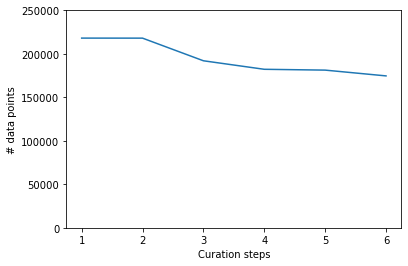

In [30]:
from matplotlib import pyplot as plt

fig, ax = plt.subplots()
ax.plot(range(1, len(curated) + 1), [df.shape[0] for df in curated])
ax.set_xlabel("Curation steps")
ax.set_ylabel("# data points")
ax.set_ylim(0, 250000);

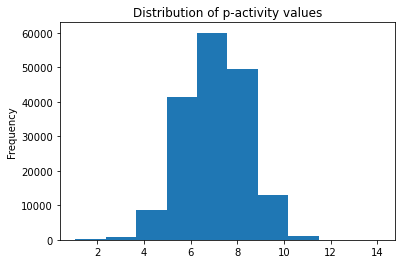

In [32]:
final["activities.standard_value"].plot.hist(title="Distribution of p-activity values", xlabel="pMeasurement");

9    96595
8    78054
Name: assays.confidence_score, dtype: int64

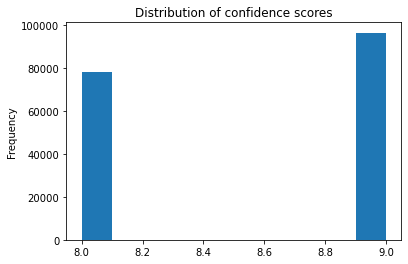

In [33]:
display(final["assays.confidence_score"].value_counts())
final["assays.confidence_score"].plot.hist(title="Distribution of confidence scores");

Distribution of document ids:

CHEMBL1908390    5890
CHEMBL3879910    3321
CHEMBL1240340    2240
CHEMBL3886441    1511
CHEMBL3639326    1502
CHEMBL1150977    1298
CHEMBL3886705    1227
CHEMBL3638592    1148
CHEMBL3638646    1104
CHEMBL3638802     997
Name: docs.chembl_id, dtype: int64

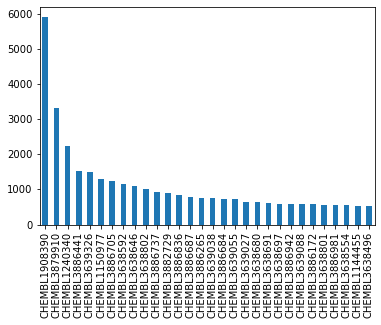

In [34]:
doc_counts = final["docs.chembl_id"].value_counts()
display(doc_counts[:10])
doc_counts[:30].plot.bar();

Distribution of clinical phases:

0    166814
4      2858
2      2096
3      1856
1      1025
Name: molecule_dictionary.max_phase, dtype: int64

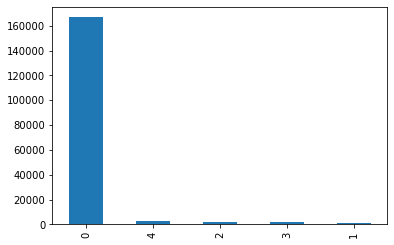

In [35]:
phase_counts = final["molecule_dictionary.max_phase"].value_counts()
display(phase_counts[:10])
phase_counts[:30].plot.bar();

Distribution of measurements per kinase:

In [66]:
counts_per_target = final.groupby("target_dictionary.chembl_id").size().sort_values(ascending=False)

In [63]:
from IPython.display import Markdown

In [67]:
md = ["| Target | Count |", 
      "|--------|-------|"]
for k, v in counts_per_target.head(20).iteritems():
    md.append(f"| [{k}](https://www.ebi.ac.uk/chembl/target_report_card/{k}/) | {v} |")
display(Markdown("\n".join(md)))

| Target | Count |
|--------|-------|
| [CHEMBL279](https://www.ebi.ac.uk/chembl/target_report_card/CHEMBL279/) | 7754 |
| [CHEMBL203](https://www.ebi.ac.uk/chembl/target_report_card/CHEMBL203/) | 5850 |
| [CHEMBL4005](https://www.ebi.ac.uk/chembl/target_report_card/CHEMBL4005/) | 5065 |
| [CHEMBL2971](https://www.ebi.ac.uk/chembl/target_report_card/CHEMBL2971/) | 5000 |
| [CHEMBL2842](https://www.ebi.ac.uk/chembl/target_report_card/CHEMBL2842/) | 4005 |
| [CHEMBL2835](https://www.ebi.ac.uk/chembl/target_report_card/CHEMBL2835/) | 3958 |
| [CHEMBL260](https://www.ebi.ac.uk/chembl/target_report_card/CHEMBL260/) | 3811 |
| [CHEMBL2147](https://www.ebi.ac.uk/chembl/target_report_card/CHEMBL2147/) | 3810 |
| [CHEMBL5145](https://www.ebi.ac.uk/chembl/target_report_card/CHEMBL5145/) | 3692 |
| [CHEMBL267](https://www.ebi.ac.uk/chembl/target_report_card/CHEMBL267/) | 3205 |
| [CHEMBL2599](https://www.ebi.ac.uk/chembl/target_report_card/CHEMBL2599/) | 3134 |
| [CHEMBL3717](https://www.ebi.ac.uk/chembl/target_report_card/CHEMBL3717/) | 3048 |
| [CHEMBL4040](https://www.ebi.ac.uk/chembl/target_report_card/CHEMBL4040/) | 2961 |
| [CHEMBL4282](https://www.ebi.ac.uk/chembl/target_report_card/CHEMBL4282/) | 2882 |
| [CHEMBL2148](https://www.ebi.ac.uk/chembl/target_report_card/CHEMBL2148/) | 2734 |
| [CHEMBL4722](https://www.ebi.ac.uk/chembl/target_report_card/CHEMBL4722/) | 2683 |
| [CHEMBL1163125](https://www.ebi.ac.uk/chembl/target_report_card/CHEMBL1163125/) | 2558 |
| [CHEMBL2815](https://www.ebi.ac.uk/chembl/target_report_card/CHEMBL2815/) | 2497 |
| [CHEMBL262](https://www.ebi.ac.uk/chembl/target_report_card/CHEMBL262/) | 2354 |
| [CHEMBL1957](https://www.ebi.ac.uk/chembl/target_report_card/CHEMBL1957/) | 2353 |

In [77]:
%matplotlib widget

In [78]:
counts_per_target.plot.bar()

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

<AxesSubplot:xlabel='target_dictionary.chembl_id'>

In [90]:
counts_per_target_and_measurement = pd.DataFrame(final.groupby(["target_dictionary.chembl_id", "activities.standard_type"]).size(), columns=["Count"])
counts_per_target_and_measurement

Count
target_dictionary.chembl_id activities.standard_type       
CHEMBL1075102               pIC50                        18
CHEMBL1075104               pIC50                       945
                            pKd                          22
                            pKi                         596
CHEMBL1075115               pIC50                         2
...                                                     ...
CHEMBL6166                  pKi                           1
CHEMBL6167                  pKd                          16
CHEMBL6186                  pIC50                         2
                            pKd                          15
CHEMBL6191                  pKd                          60

[930 rows x 1 columns]

In [92]:
counts_per_target_and_measurement.sort_values(by="Count", ascending=False).plot.bar()

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

<AxesSubplot:xlabel='target_dictionary.chembl_id,activities.standard_type'>